# Predicting Doctor Appointment No-Shows
***

## Table of Contents
* [Reloading](#reloading)
* [Introduction](#introduction)
* [Data Wrangling](#data_wrangling)
    * [General Properties](#general_properties)
    * [Data Cleaning](#data_cleaning)
        * [Checking for Duplicates](#cleaning_duplicates)
        * [Appointment ID](#cleaning_appointment_id)
        * [Scheduled Day](#cleaning_scheduled_day)
        * [Appointment Day](#cleaning_appointment_day)
        * [Gender](#cleaning_gender)
        * [Age](#cleaning_age)
        * [Bolsa Familia](#cleaning_bolsa_familia)
        * [Hypertension](#cleaning_hypertension)
        * [Diabetes](#cleaning_diabetes)
        * [Number of Handicaps](#cleaning_number_handicaps)
        * [SMS Received](#cleaning_sms_received)
        * [No Show](#cleaning_no_show)
        * [Neighborhood](#cleaning_neighborhood)
        * [Patient ID](#cleaning_patient_id)
            * [Patient ID Consistency](#cleaning_patient_id_consistency)
* [Additional Data](#addtl_data)
* [Feature Engineering](#feat_engineering)
* [Exploratory Data Analysis](#eda)
    * [Initial Exploration and Further Cleaning](#further_cleaning)
    * [Univariate Plots and Analysis](#univariate)

<a id='introduction'></a>

## Introduction
***

In this project, my aim is to determine what patient characteristics are connected with not showing up to a doctor's appointment by analyzing a data set of over 110K medical appointments in Vitória, Espírito Santo, Brazil provided by JoniHoppen on [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments).

<a id='data_wrangling'></a>

## Data Wrangling
***

In [ ]:
import pandas as pd
import numpy as np
import geocoder
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
matplotlib.rcParams.update({'font.size': 12.5})
import seaborn as sns
import folium
from folium.plugins import HeatMap
import scipy.stats as stats
import config
API_KEY = config.api_key

<a id='general_properties'></a>

### General Properties

In [ ]:
orig = pd.read_csv('KaggleV2-May-2016.csv')
orig.head()

In [ ]:
# Number of records
n = len(orig)
n

In [ ]:
# Rename fields to have more consistent formatting and to English where appropriate
orig.columns = ['PatientID', 'AppointmentID', 'Gender', 'ScheduledDay',
              'AppointmentDay', 'Age', 'Neighborhood', 'BolsaFamilia', \
              'Hypertension', 'Diabetes', 'Alcoholism', 'NumHandicaps', \
              'SMSReceived', 'NoShow']

In [ ]:
# Number of nulls
orig.isnull().sum()

> There are no null records in any of the fields

In [ ]:
# Data types
orig.dtypes

<a id='data_cleaning'></a>

### Data Cleaning

<a id='cleaning_duplicates'></a>

#### Checking for Duplicates

In [ ]:
orig.duplicated(keep=False).any()

In [ ]:
orig.duplicated('AppointmentID', keep=False).any()

> There are no duplicate entries and no duplicate AppointmentIDs.

<a id='cleaning_appointment_id'></a>

#### Appointment ID

In [ ]:
min_apptID = orig['AppointmentID'].min()
max_apptID = orig['AppointmentID'].max()
print('{} - {}'.format(min_apptID, max_apptID))

> All of the appointment IDs are 7 digits long, and are between these values

In [ ]:
# AppointmentIDs are identifiers, so they are also converted to strings
orig['AppointmentID'] = orig['AppointmentID'].astype(str)

<a id='cleaning_scheduled_day'></a>

#### Scheduled Day
ScheduledDay represents the day that a patient created the appointment.

In [ ]:
# Convert the scheduled day to a datetime
orig['ScheduledDay'] = pd.to_datetime(orig['ScheduledDay'])

# Verify that ScheduledDay is in a datetime format
orig['ScheduledDay'].dtype

In [ ]:
# Check that the <M8[ns] is a datetime format
np.dtype('datetime64[ns]') == np.dtype('<M8[ns]')

In [ ]:
# Verify that all records were converted to valid datetimes
np.isnat(orig['ScheduledDay']).sum()

In [ ]:
# Include a field for scheduled day in a date format
orig['ScheduledDayDate'] = orig['ScheduledDay'].dt.date

In [ ]:
# The first date and time an appointment was scheduled 
np.min(orig['ScheduledDay'])

In [ ]:
# The last date and time an appointment was scheduled 
np.max(orig['ScheduledDay'])

In [ ]:
np.max(orig['ScheduledDay']) - np.min(orig['ScheduledDay'])

> All appointments are created within an about 7-month time frame.

<a id='cleaning_appointment_day'></a>

#### Appointment Day
AppointmentDay is the day of the doctor's appointment.

In [ ]:
# Convert the appointment day to a datetime
orig['AppointmentDay'] = pd.to_datetime(orig['AppointmentDay'])

# Verify that AppointmentDay is in a datetime format
orig['AppointmentDay'].dtype

In [ ]:
# Verify that all records were converted to valid datetimes
np.isnat(orig['AppointmentDay']).sum()

In [ ]:
# Since appointment day doesn't have a time, include another field for 
# it in a date format
orig['AppointmentDayDate'] = orig['AppointmentDay'].dt.date

# The first scheduled appointment
np.min(orig['AppointmentDay'])

In [ ]:
# The last scheduled appointment
np.max(orig['AppointmentDay'])

In [ ]:
np.max(orig['AppointmentDay']) - np.min(orig['AppointmentDay'])

> While the appointments were scheduled during a 7-month period, they all were scheduled for a 40-day period.

<a id='cleaning_gender'></a>

#### Gender

In [ ]:
# Gender data is clean
orig['Gender'].value_counts()

In [ ]:
# Encode gender as binary, 0 = male, 1 = female 
orig['Gender'] = np.where(orig['Gender'].values == 'F', 1, 0)
orig['Gender'].value_counts()

<a id='cleaning_age'></a>

#### Age

In [ ]:
age_counts = orig['Age'].value_counts()
age_counts.index.sort_values()

In [ ]:
# Drop the record with an age of -1
invalid_age = orig[orig['Age'] == -1]['PatientID']
orig.drop(invalid_age.index, inplace=True)

> I removed the record with the age of -1.  All of the other ages are plausible; although the age of 115 is improbable, it is still possible.

<a id='cleaning_bolsa_familia'></a>

#### Bolsa Família

[Bolsa Família](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia) is a social welfare program in Brazil.  A value of 1 for this field means that the patient receives financial aid from the Brazilian government under this progrm.

In [ ]:
# BolsaFamilia data is clean
orig['BolsaFamilia'].value_counts()

<a id='cleaning_hypertension'></a>

#### Hypertension

In [ ]:
# Hypertension data is clean
orig['Hypertension'].value_counts()

<a id='cleaning_diabetes'></a>

#### Diabetes

In [ ]:
# Diabetes data is clean
orig['Diabetes'].value_counts()

<a id='cleaning_alcoholism'></a>

#### Alcholism

In [ ]:
# Alcoholism data is clean
orig['Alcoholism'].value_counts()

<a id='cleaning_number_handicaps'></a>

#### Number of Handicaps

In [ ]:
# This represents the number of handicaps a person has (as defined by the publisher of the dataset)
# All people having between 0-4 handicaps seems reasonable
orig['NumHandicaps'].value_counts()

<a id='cleaning_sms_received'></a>

#### SMS Received
This field indicates whether or not a patient was sent an appointment reminder by the facility in the form of a text message.

In [ ]:
# SMS Received data is clean
orig['SMSReceived'].value_counts()

<a id='cleaning_no_show'></a>

#### No Show

A value of yes for NoShow means that the patient did not show up to their appointment (they were a 'no show').

In [ ]:
orig['NoShow'].value_counts()

In [ ]:
# Convert NoShow to zeros and ones
orig['NoShow'] = np.where(orig['NoShow'].values == 'Yes', 1, 0)
orig['NoShow'].value_counts()

<a id='cleaning_neighborhood'></a>

#### Neighborhood

The Neighborhood field has the neighborhood of the doctor's facility.

In [ ]:
neighborhood_counts = orig['Neighborhood'].value_counts()
neighborhood_counts[:11]

In [ ]:
# Number of unique neighborhoods
orig['Neighborhood'].nunique()

In [ ]:
# Organize the neighborhoods into a dataframe
geo = pd.DataFrame(neighborhood_counts.index, columns = ['neighborhood'])
geo.head()

In [ ]:
# Geocode the neighborhood data
for i, row in geo.iterrows():
    # Use Bing    
    full_neighborhood = row.str.title() + ', Vitória, Espírito Santo, Brazil'
    result = geocoder.bing(full_neighborhood, key=API_KEY)
    
    geo.at[i, 'status'] = result.status
    geo.at[i, 'lat'] = result.lat
    geo.at[i, 'lng'] = result.lng
    geo.at[i, 'bing_neighborhood'] = result.neighborhood
    geo.at[i, 'city'] = result.city
    geo.at[i, 'state'] = result.state
    geo.at[i, 'country'] = result.country
    
    # If Bing returns None for neighborhood, use Google
    if geo.loc[i, 'bing_neighborhood'] is None or \
       geo.loc[i, 'bing_neighborhood'] == 'None':
        result = geocoder.google(full_neighborhood)
        
        geo.at[i, 'status'] = result.status
        geo.at[i, 'lat'] = result.lat
        geo.at[i, 'lng'] = result.lng
        
        if result.county == 'Vitória': # Google uses county where Bing uses city
            geo.at[i, 'city'] = result.county
        geo.at[i, 'state'] = result.state
        if result.country == 'BR':
            geo.at[i, 'country'] = 'Brazil'

# Assign Nazareth manually
full_neighborhood = 'Nazareth' + ', Vitória, Espírito Santo, Brazil'
result = geocoder.google(full_neighborhood)
geo.at[73, 'status'] = result.status
geo.at[73, 'lat'] = result.lat
geo.at[73, 'lng'] = result.lng
geo.at[73, 'state'] = 'ES'

In [ ]:
geo.head()

In [ ]:
# Check that all the neighborhoods are unique
(geo['bing_neighborhood'].value_counts() == 1).all()

In [ ]:
# Check that each neighborhood returns a unique location
not any(geo.duplicated(['lat', 'lng']))

In [ ]:
# Verify that all of the locations are in Vitória, Espírito Santo, Brazil
print((geo['status'] == 'OK').all())
print((geo['city'] == 'Vitória').all())
print((geo['state'] == 'ES').all())
print((geo['country'] == 'Brazil').all())

<a id='cleaning_patient_id'></a>

#### Patient ID

In [ ]:
# Convert patient ID to a string, as it is meant to be an identifier not a number
orig['PatientID'] = orig['PatientID'].astype(int).astype(str)

# All identifiers are 7-15 digits long, most have at least 10
lens = orig['PatientID'].apply(len)
pd.value_counts(lens)

> Most of the patient IDs are at least 10 digits long.  There is no consistent length for this field, and it is unknown, and impossible to know, if some of these patient identifiers are flawed.  It is an identifier and does not need to be operated on or with, therefore none of these records will be removed.

<a id='cleaning_patient_id_consistency'></a>

##### PatientID Consistency

In [ ]:
# Number of appointments per PatientID
num_appts_by_patient = orig.groupby('PatientID')['AppointmentID'].count()
num_appts_by_patient[:5]

There are multiple appointments for some patients, so I am checking that the information for each patient across the different appointments is the same.

In [ ]:
# All have the same gender
unique_gender_vals = orig.groupby('PatientID')['Gender'].nunique()
len(unique_gender_vals[unique_gender_vals > 1])

In [ ]:
# All have the same BolsaFamilia status
unique_bf_vals = orig.groupby('PatientID')['BolsaFamilia'].nunique()
len(unique_bf_vals[unique_bf_vals > 1])

In [ ]:
# All have the same value for Hypertension
unique_hypertension_vals = orig.groupby('PatientID')['Hypertension'].nunique()
len(unique_hypertension_vals[unique_hypertension_vals > 1])

In [ ]:
# All have the same value for Diabetes
unique_diabetes_vals = orig.groupby('PatientID')['Diabetes'].nunique()
len(unique_diabetes_vals[unique_diabetes_vals > 1])

In [ ]:
# All have the same value for Alcoholism
unique_alcoholism_vals = orig.groupby('PatientID')['Alcoholism'].nunique()
len(unique_alcoholism_vals[unique_alcoholism_vals > 1])

In [ ]:
# All have the same value for NumHandicaps
unique_handicaps_vals = orig.groupby('PatientID')['NumHandicaps'].nunique()
len(unique_handicaps_vals[unique_handicaps_vals > 1])

In [ ]:
# All have the same value for Neighborhood - so patients kept the same doctor's office/hospital
unique_neighborhood_vals = orig.groupby('PatientID')['Neighborhood'].nunique()
len(unique_neighborhood_vals[unique_neighborhood_vals > 1])

In [ ]:
# Appointments occur with a 7-month period, so the entries for a patient's ages should be within a year of each other
unique_age_vals = orig.groupby('PatientID')['Age'].nunique()
not_unique_age_vals = unique_age_vals[unique_age_vals > 1]

# Patients with more than one appointment, all have less than 2 values for age
len(not_unique_age_vals[not_unique_age_vals > 2])

In [ ]:
# Get the information for the patients with more than one age
patients_multiple_ages = list(not_unique_age_vals.index)
multiple_ages_info = orig[orig['PatientID'].isin(patients_multiple_ages)].sort_values('PatientID')
multiple_ages_info.head()

In [ ]:
# Get the difference between each patient's ages
max_age = multiple_ages_info.groupby('PatientID')['Age'].max()
min_age = multiple_ages_info.groupby('PatientID')['Age'].min()
age_diff = max_age - min_age
age_diff.head()

In [ ]:
# Each patient's ages are within one year of each other
age_diff[age_diff <= 1].all()

<a id='addtl_data'></a>

## Additional Data
***

I obtained weather data for Vitória airport from [wunderground.com](https://www.wunderground.com/history/airport/SBVT/2016/4/29/DailyHistory.html) for the appointment dates.

In [ ]:
xlsx = pd.ExcelFile('vitoria_weather.xlsx')
weather = pd.read_excel(xlsx, 'Sheet1', skiprows = 2)
weather['Datetime'] = pd.to_datetime(weather['Date'])
weather['Date'] = weather['Datetime'].dt.date
weather.head()

In [ ]:
all(weather['visibility_high'] == 12)

In [ ]:
# Merge appointment data with weather data
ow = pd.merge(orig, weather, left_on='AppointmentDayDate', right_on='Date', how='left')

# Remove the visibility_high field since it has the same value for every date
ow = ow.drop(['Date', 'Datetime', 'visibility_high'], axis = 1)

# Check there are no null values
all(ow.isnull().sum() == 0)

<a id='feat_engineering'></a>

## Feature Engineering
***

### Differences Between Scheduled and Appointment Days

In [ ]:
# Add a field for the number of days between scheduling and the appointment
ow['DayDiff'] = ((ow['AppointmentDayDate'] - ow['ScheduledDayDate'])/np.timedelta64(1, 'D')).astype(int)
ow[['ScheduledDayDate', 'AppointmentDayDate', 'DayDiff']].sort_values(by = 'DayDiff')[:7]

We can see that we need to do some data cleaning as there are five appointments that were shown to be scheduled days after the appointment itself.  These are obviously errors and since there are only five, they were removed from the data.

In [ ]:
ow = (ow[ow['DayDiff'] >= 0])

### Day of Week and Weekend

In [ ]:
# Add a field for whether the AppointmentDay is during the weekend (1) or not (0)
ow['DayOfWeek'] = pd.to_datetime(ow['AppointmentDay']).dt.dayofweek
ow['Weekend'] = np.where(ow['DayOfWeek'] >= 5, 1, 0)

# Number of weekend appointments
ow['Weekend'].sum()

<a id='eda'></a>

## Exploratory Data Analysis
***

<a id='further_cleaning'></a>

### Initial Exploration and Further Cleaning

#### Number of appointments by patient

In [ ]:
num_appts_by_patient.sort_values(ascending = False)[:10]

> Oddly there are patients with a significant number of appointments.  The appointments only occurred during a 40-day period, so even if a patient had an appointment every day during this period, they would still only have a maximum of 40 appointments.

In [ ]:
# Bin the number of appointments per patient
bins = [0, 1, 2, 3, 4, 5, 10, 15, 20, 30, 40, 50, 80]
bin_names = ["1", "2", "3", "4", "5", "6-10", "11-15", "16-20", "21-30", "31-40", "41-50", "50+"]

num_appts_binned = pd.cut(num_appts_by_patient, bins = bins, labels = bin_names).value_counts()
num_appts_binned.sort_index()

In [ ]:
num_appts_by_patient.hist(bins = 100)
plt.title("Number of Appointments Made Per Patient");

The number of appointments is very skewed to the right.  The majority of patients made three or fewer appointments during this 40-day time period, but the data is very long tailed with upto 88 appointments per patient.

In [ ]:
# Inspect the patient with 88 appointments
most_appts = ow[ow['PatientID'] == '822145925426128'].sort_values(by = 'ScheduledDay')
most_appts

In [ ]:
most_appts['NoShow'].sum()

> From analyzing this and other patients' appointments, I found that many appointments were made for a certain day, and then later another appointment was made for that same day.  We can see above that the patient made an appointment for April 29, three different times.  For the patient above, they made the appointments within farily quick succession of each other.  However other patients, as shown below, seemed to make appointments in advance and then as the appointment got closer rescheduled it.

In [ ]:
ow[ow['PatientID'] == '99992299798515'].sort_values(by = 'ScheduledDay')

In [ ]:
ow[ow['PatientID'] == '111415561531417'].sort_values(by = 'ScheduledDay').iloc[:, :14]

In the case above, the patient made an appointment for June 6, and on the same day makes an appoitment for May 13.  Then 15 days later makes another appointment for/reschedules the June 6 appointment.  Finally they make another appointment for three days before their scheduled appointment.  I would guess that they rescheduled their appointment for an earlier day, so it may be illogical to term their non-attendance as a "no show."  Unfortunately this is just a hypothesis, and since there is neither extra data, nor an explanation for the multiple appointments, this cannot be confirmed.  If more information later became available this aspect of the data could possibly be addressed.

To address the issue of multiple appointments made for the same day, I made the decision to only keep the last appointment made on the same day as an already made appointment.  Although records were removed, this data was preserved in the extra fields of the number of times the appointment for that day was scheduled and the time difference between the first and last scheduling.

In [ ]:
# Sort the dataframe and update the index, so that the records are in
# order of when they were made
ow = ow.sort_values(by = ['PatientID', 'ScheduledDay', 'AppointmentDay'])
ow.index = range(1,len(ow) + 1)
ow.head()

In [ ]:
# Aggregate data by PatientID and AppointmentDay, and assemble all the AppointmentIDs associated
# with them into a tuple
df_appt_id_list = ow.groupby(['PatientID', 'AppointmentDay'], as_index=False)['AppointmentID']. \
                apply(tuple).reset_index()
df_appt_id_list.columns = ['PatientID', 'AppointmentDay', 'AppointmentIDList']
df_appt_id_list.head()

In [ ]:
# Create field for the last appointment created for that date
df_appt_id_list['LastAppt'] = df_appt_id_list['AppointmentIDList'].apply(lambda x: x[len(x) - 1])

# Create field for the number of times that appointment was scheduled
df_appt_id_list['NumTimesScheduled'] = df_appt_id_list['AppointmentIDList'].apply(len)

df_appt_id_list[25:30]

In [ ]:
# Create function for looking up the time difference between
# the ScheduledDay for the appointments that have more than one ID
# else the difference is 0
def get_days_bw_scheduling(x, df):
    if len(x) == 1:
        return 0
    else:
        first_sch = df[df['AppointmentID'] == x[0]].iloc[0, 3] # first scheduling
        last_sch = df[df['AppointmentID'] == x[len(x) - 1]].iloc[0, 3] # last scheduling
        days = (last_sch - first_sch)/np.timedelta64(1, 'D')
        return days # return days difference as float

In [ ]:
df_appt_id_list['DaysBWScheduling'] = df_appt_id_list['AppointmentIDList'].apply(lambda x: get_days_bw_scheduling(x, ow))

In [ ]:
# Merge this data with the original dataframe
df = pd.merge(ow, df_appt_id_list, left_on = ['PatientID', 'AppointmentDay', 'AppointmentID'], 
              right_on = ['PatientID', 'AppointmentDay', 'LastAppt'])

# Remove unnecessary and redundant columns
df.drop(['AppointmentIDList', 'LastAppt'], axis = 1, inplace = True)
df.head()

In [ ]:
len(ow) - len(df)

> Note that 8718 records that represented the extra appointments made all on the same day were removed from the data.

In [ ]:
#df.to_csv('df.csv')

<a id='univariate'></a>

### Univariate Plots and Analysis

<a id='reloading'></a>
## Reloading the Data

In [16]:
import pandas as pd
import numpy as np
import geocoder
pd.options.mode.chained_assignment = None
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
matplotlib.rcParams.update({'font.size': 12.5})
import seaborn as sns
import scipy.stats as stats
import config
API_KEY = config.api_key

In [2]:
df = pd.read_csv('df.csv')

In [3]:
df['PatientID'] = df['PatientID'].astype(str)
df['AppointmentID'] = df['AppointmentID'].astype(str)
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['ScheduledDayDate'] = pd.to_datetime(df['ScheduledDayDate']).dt.date
df['AppointmentDayDate'] = pd.to_datetime(df['AppointmentDayDate']).dt.date

In [4]:
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.head()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,BolsaFamilia,Hypertension,Diabetes,...,wind_avg,precip_in,rain,thunderstorm,fog,DayDiff,DayOfWeek,Weekend,NumTimesScheduled,DaysBWScheduling
0,11111462625267,5715720,1,2016-05-18 14:58:29,2016-06-08,65,REPÚBLICA,0,1,0,...,9,0.04,1,0,0,21,2,0,1,0.0
1,111124532532143,5531224,0,2016-03-31 09:17:26,2016-05-03,9,MARIA ORTIZ,0,0,0,...,5,0.00,0,0,0,33,1,0,1,0.0
2,111124532532143,5624030,0,2016-04-26 15:05:58,2016-06-01,9,MARIA ORTIZ,0,0,0,...,4,0.01,0,1,0,36,2,0,1,0.0
3,11114485119737,5621757,1,2016-04-26 10:46:38,2016-05-25,12,MARIA ORTIZ,0,0,0,...,12,0.00,0,0,0,29,2,0,1,0.0
4,11116239871275,5625265,1,2016-04-27 07:05:38,2016-04-29,13,SÃO PEDRO,0,0,0,...,11,0.01,0,0,0,2,4,0,1,0.0


In [5]:
# Number of records in the cleaned dataset
len(df)

101803

In [6]:
xlsx = pd.ExcelFile('vitoria_weather.xlsx')
weather = pd.read_excel(xlsx, 'Sheet1', skiprows = 2)
weather['Datetime'] = pd.to_datetime(weather['Date'])
weather['Date'] = weather['Datetime'].dt.date
weather.head()

,Date,temp_high,temp_avg,temp_low,humidity_high,humidity_avg,humidity_low,visibility_high,visibility_avg,visibility_low,wind_high,wind_avg,precip_in,rain,thunderstorm,fog,Datetime
0,2016-04-29,75,73,71,88,76,64,12,7,6,16,11,0.01,0,0,0,2016-04-29
1,2016-04-30,80,74,69,88,79,70,12,7,6,13,7,0.00,0,0,0,2016-04-30
2,2016-05-01,77,73,69,83,67,52,12,6,4,17,13,0.00,1,0,0,2016-05-01
3,2016-05-02,81,74,66,83,58,33,12,8,6,17,11,0.00,0,0,0,2016-05-02
4,2016-05-03,79,70,62,88,80,61,12,7,6,17,5,0.00,0,0,0,2016-05-03


#### Patient Characteristics

In [7]:
# Get unique patients when getting frequency of patient characteristics
# Since all the patient characteristics remain the same, they will remain the same, but
# mean will take the average age and the proportion of no shows
unique_patients = df.groupby('PatientID').mean()
len(unique_patients)

62298

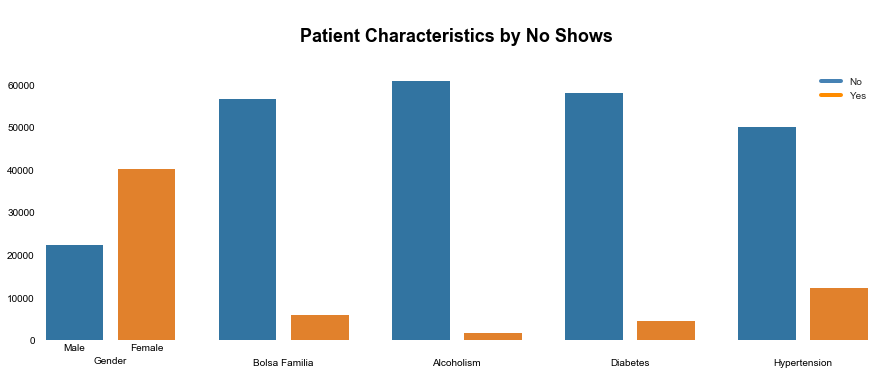

In [8]:
# Plot binary patient characteristics
fields = ['Gender', 'BolsaFamilia', 'Alcoholism', 'Diabetes', 'Hypertension']
xlabels = ['Gender', 'Bolsa Familia', 'Alcoholism', 'Diabetes', 'Hypertension']
gender_labels = ['Male', 'Female']
labels = ['No', 'Yes']

fig, axes = plt.subplots(1, 5, figsize = (15, 5), sharey = True)

i = 0
for ax in axes.reshape(-1):
    sns.countplot(ax = ax, x = fields[i], data = unique_patients)
    sns.set_style("white")
    ax.tick_params(length = 0)
    sns.despine(left = True, bottom = True)
    if i == 0:
        ax.set(xticklabels=['Male', 'Female'])
        ax.set(xlabel = xlabels[i], ylabel = '')
    else:
        ax.set(xticklabels=['', ''])
        ax.set(xlabel = '\n' + xlabels[i], ylabel = '')
    if i == 2:
        ax.set_title('\nPatient Characteristics by No Shows\n', fontsize = 18, fontweight = 'bold')
    i += 1
    
custom_lines = [Line2D([0], [0], color = 'steelblue', lw=4),
                Line2D([0], [0], color = 'darkorange', lw=4)]
ax.legend(custom_lines, ['No', 'Yes'])
plt.show()

In [15]:
fields = ['Women', 'Bolsa Familia', 'Alcoholic', 'Diabetes', 'Hypertension']
char_props = [round(unique_patients['Gender'].mean(), 3),
              round(unique_patients['BolsaFamilia'].mean(), 3),
              round(unique_patients['Alcoholism'].mean(), 3),
              round(unique_patients['Diabetes'].mean(), 3),
              round(unique_patients['Hypertension'].mean(), 3)]

pd.DataFrame(stats, index = fields, columns = ['Proportion'])

,Proportion
Women,0.643
Bolsa Familia,0.093
Alcoholic,0.024
Diabetes,0.071
Hypertension,0.197


In [10]:
# Average number of appointments per patient
round(df.groupby('PatientID')['AppointmentID'].count().mean(), 2)

1.63

##### Patient Characteristics by No Shows

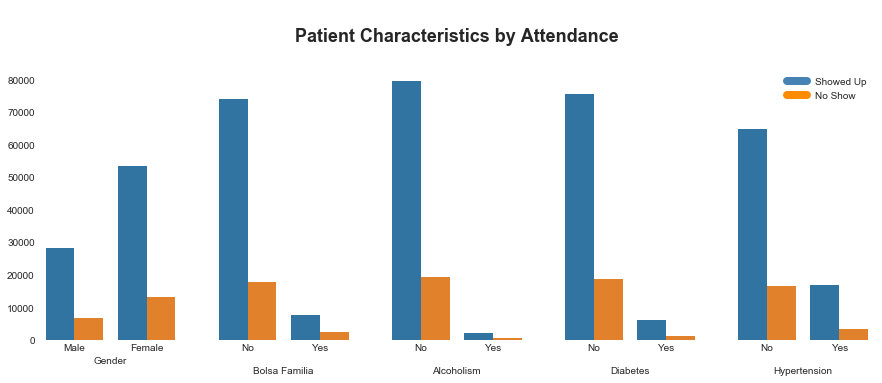

In [11]:
# Plot binary patient characteristics by attendance - not aggregated (by individual appointment)
fields = ['Gender', 'BolsaFamilia', 'Alcoholism', 'Diabetes', 'Hypertension']
xlabels = ['Gender', 'Bolsa Familia', 'Alcoholism', 'Diabetes', 'Hypertension']
gender_labels = ['Male', 'Female']
labels = ['No', 'Yes']

fig, axes = plt.subplots(1, 5, figsize = (15, 5), sharey = True)

i = 0
for ax in axes.reshape(-1):
    sns.countplot(ax = ax, x = fields[i], hue = 'NoShow', data = df)
    sns.set_style("white")
    ax.tick_params(length = 0)
    ax.legend_.remove()
    sns.despine(left = True, bottom = True)
    if i == 0:
        ax.set(xticklabels=['Male', 'Female'])
        ax.set(xlabel = xlabels[i], ylabel = '')
    else:
        ax.set(xticklabels=['No', 'Yes'])
        ax.set(xlabel = '\n' + xlabels[i], ylabel = '')
    if i == 2:
        ax.set_title('\nPatient Characteristics by Attendance\n', fontsize = 18, fontweight = 'bold')
    
    i += 1
    
custom_lines = [Line2D([0], [0], color = 'steelblue', lw=8),
                Line2D([0], [0], color = 'darkorange', lw=8)]
ax.legend(custom_lines, ['Showed Up', 'No Show'])
plt.show()

In [17]:
fields = ['Gender', 'BolsaFamilia', 'Alcoholism', 'Diabetes', 'Hypertension']

# create dictionary of dataframes of proportions of no shows for each field
no_show_props = {}
for field in fields:
    no_show_props[field] = (df.groupby([field,'NoShow'])['NoShow'].count()/
                            df.groupby(field)['NoShow'].count()).rename('prop').reset_index()
    no_show_props[field] = no_show_props[field][no_show_props[field]['NoShow'] == 1] # only keep no shows

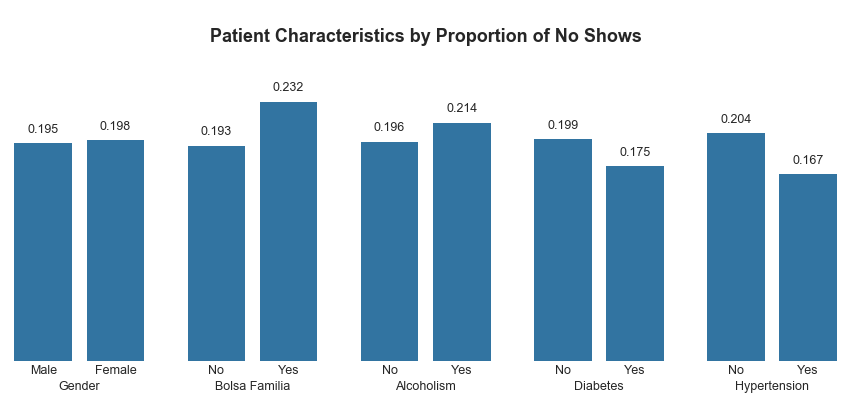

In [18]:
# Plot proportion of no shows by binary patient characteristics
fig, axes = plt.subplots(1, 5, figsize = (15, 5), sharey = True)

i = 0
for ax in axes.reshape(-1):
    sns.barplot(ax = ax, x = fields[i], y = 'prop', hue = 'NoShow', data = no_show_props[fields[i]]);
    sns.set_style("white")
    ax.tick_params(length = 0)
    ax.legend_.remove()
    sns.despine(left = True, bottom = True)
    ax.set(yticklabels='')
    if i == 0:
        ax.set(xticklabels=['Male', 'Female'])
        ax.set(xlabel = xlabels[i], ylabel = '')
    else:
        ax.set(xticklabels=['No', 'Yes'])
        ax.set(xlabel = xlabels[i], ylabel = '')
    if i == 2:
        ax.set_title('\nPatient Characteristics by Proportion of No Shows\n\n', fontsize = 18, fontweight = 'bold')
    i += 1
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,
                height + 0.01,
                '{:0.3f}'.format(height),
                ha="center") 
plt.show()

#### Age

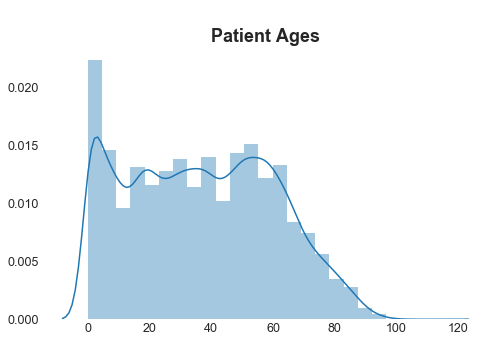

In [21]:
# Only plot the average age for each unique patient that appears in the dataset
fig = plt.figure(figsize = (8, 5))
sns.distplot(unique_patients['Age'], bins = 25)
sns.despine(left = True, bottom = True)
plt.title('\nPatient Ages', fontsize = 18, fontweight = 'bold')
plt.xlabel('')
plt.show();

In [22]:
bins = [0, 11, 21, 41, 61, 81, 100, 116]
bin_names = ["0-10", "11-20", "21-40", "41-60", "61-80", "81-99", "100+"]

ages_bins = pd.cut(unique_patients['Age'], bins = bins, labels = bin_names).value_counts()
ages_bins.sort_index()

0-10      9984
11-20     7608
21-40    15653
41-60    16452
61-80     9130
81-99     1439
100+         4
Name: Age, dtype: int64

In [23]:
df['Age'].describe()

count    101803.000000
mean         37.059900
std          23.214054
min           0.000000
25%          18.000000
50%          37.000000
75%          56.000000
max         115.000000
Name: Age, dtype: float64

#### Number of Handicaps

In [ ]:
fig = plt.figure(figsize = (8, 5))
sns.countplot(unique_patients['NumHandicaps'])
sns.despine(left = True, bottom = True)
plt.title('\nNumber of Patient Handicaps\n', fontsize = 18, fontweight = 'bold')
plt.xlabel('')
plt.ylabel('')
plt.show();

In [ ]:
unique_patients['NumHandicaps'].value_counts()

In [ ]:
round(unique_patients['NumHandicaps'].mean(), 3)

#### Appointments by Day

In [ ]:
df['AppointmentDay'].value_counts().sort_index().resample('D').sum()

There were only 38 appointments on the weekend, all occurring on Saturday, May 14th.  Besides the weekends, there were no appointments on Monday, May 23; Thursday, May 26; or Friday, May 27.

May 26 was the optional holiday of Corpus Christi, however I couldn't find any reason as to why there is no data for the 23rd or 27th.

In [ ]:
df['Weekend'].sum()

In [ ]:
# Exclude weekends and weekdays with no appointments
fig = plt.figure(figsize = (12, 8))
no_weekends = df[df['Weekend'] == 0]
appt_by_day = no_weekends.groupby('AppointmentDay')['AppointmentDay'].count()
appt_by_day.plot(linewidth = 2)
sns.despine(left = True, bottom = True)
plt.title('\nNumber of Appointments by Day\n', fontsize = 18, fontweight = 'bold')
plt.xlabel('');

The weekends and weekdays with no appointments were excluded from the graph in order to focus more on the normal fluctuations without the low outliers affecting the graph.

In [ ]:
# Average number of appointments per day (on non-zero days and weekdays)
round(df[df['Weekend'] == 0]['AppointmentDay'].value_counts().mean(), 2)

In [ ]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

fig, ax = plt.subplots(figsize = (8, 5))
df['DayOfWeek'].value_counts().sort_index().plot(ax = ax, kind = 'bar', color = 'steelblue')
ax.set(xticklabels = days_of_week)
sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.title('\nAppointments by Day of Week\n', fontsize = 18, fontweight = 'bold');

#### Scheduled Appointments By Day

In [ ]:
sched_date_counts = df.groupby('ScheduledDayDate')['ScheduledDayDate'].count()

# Find index of first scheduled date that is an appointment date
sched_len = len(sched_date_counts)
first_ix = list(sched_date_counts.index > df['AppointmentDayDate'].min()).index(True)

# Use orange for the appointments scheduled during the time period that
# the appointments took place
colors = ['steelblue'] * first_ix
colors.extend(['darkorange'] * (sched_len-first_ix))

fig, ax = plt.subplots(figsize = (12, 8))
ax.bar(sched_date_counts.index, sched_date_counts, color = colors)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B\n%Y'))

custom_lines = [Line2D([0], [0], color = 'steelblue', lw=4),
                Line2D([0], [0], color = 'darkorange', lw=4)]
ax.legend(custom_lines, ['Prior to appointments starting',
                         'During time period when appointments started'])

sns.despine(left = True, bottom = True)
plt.xticks(rotation = 45, fontsize = 13)
plt.title('\nNumber of Scheduled Appointments by Day\n', fontsize = 18, fontweight = 'bold');

In [ ]:
# Proportion of appointments that were scheduled during the time period that
# the appointments took place
sched_date_counts[first_ix:].sum()/sched_date_counts.sum()

#### Neighborhoods

In [ ]:
neighborhood_counts = df['Neighborhood'].value_counts()

fig, ax = plt.subplots(figsize = (10, 15))
neighborhood_counts.sort_values().plot(kind = 'barh', color = 'steelblue')
sns.despine(left = True, bottom = True)
plt.yticks(fontsize = 12)
plt.title('\nAppointments by Neighborhood\n', fontsize = 18, fontweight = 'bold');

In [ ]:
neighborhood_df = pd.DataFrame(neighborhood_counts).reset_index().rename(columns = {'index': 'neighborhood',
                                                                                    'Neighborhood': 'count'})
# join neighborhood_counts with geo dataframe
neighborhood_lat_lng = pd.merge(neighborhood_df, geo[['neighborhood', 'lat', 'lng']], on = 'neighborhood')

# convert counts to proportions
neighborhood_lat_lng['prop'] = neighborhood_lat_lng['count']/len(df)
neighborhood_lat_lng.head()

In [ ]:
hood_lst = neighborhood_lat_lng[['lat', 'lng', 'prop']].values.tolist() # need to pass list to folium

m = folium.Map(location=[-20.292474, -40.317893], tiles='stamentoner', zoom_start = 13)
m.add_child(folium.plugins.HeatMap(hood_lst))

#### SMS Received and No Shows

In [ ]:
# Plot binary appointment characteristics
fields = ['SMSReceived', 'NoShow']
xlabels = ['SMS Received', 'No Show']
labels = ['No', 'Yes']

fig, axes = plt.subplots(1, 2, figsize = (8, 5), sharey = True)

i = 0
for ax in axes.reshape(-1):
    sns.countplot(ax = ax, x = fields[i], data = unique_patients)
    sns.set_style("white")
    ax.tick_params(length = 0)
    sns.despine(left = True, bottom = True)
    ax.set(xticklabels=['', ''])
    ax.set(xlabel = '\n' + xlabels[i], ylabel = '')
    i += 1
    
custom_lines = [Line2D([0], [0], color = 'steelblue', lw=4),
                Line2D([0], [0], color = 'darkorange', lw=4)]
ax.legend(custom_lines, ['No', 'Yes'])
plt.show()

In [ ]:
# Proportion of sms received
df['SMSReceived'].mean()

In [ ]:
# Proportion of no shows
df['NoShow'].mean()

#### Number of Times an Appointment was Scheduled

In [ ]:
df['NumTimesScheduled'].describe()

In [ ]:
# Append missing values from value_counts index
missing_times_sched = pd.Series([0, 0], index = [7, 9])
missing_times_sched

num_times_sched = (df['NumTimesScheduled'].value_counts()).append(missing_times_sched).\
                   sort_index()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
num_times_sched.plot(kind = 'bar', color = 'steelblue')

plt.xticks(rotation = 0)
plt.ylabel('')
sns.despine(left = True, bottom = True)
plt.title('\nNumber of Times an Appointment was Scheduled\n', fontsize = 18, fontweight = 'bold');

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
num_times_sched.plot(kind = 'bar', color = 'steelblue')

plt.xticks(rotation = 0)
plt.ylabel('')
ax.set_yscale('log')
sns.despine(left = True, bottom = True)
plt.title('\nNumber of Times an Appointment was Scheduled\n', fontsize = 18, fontweight = 'bold')
plt.suptitle('\nLog Scale\n', fontsize = 16);

#### Days Between Scheduling and Appointment

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
df['DayDiff'].hist(bins = 25)
sns.despine(left = True, bottom = True)
plt.title('\nDays Between Scheduling and Appointment\n', fontsize = 18, fontweight = 'bold')
plt.show();

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
df['DayDiff'].hist(bins = 25)
sns.despine(left = True, bottom = True)
ax.set_yscale('log')
plt.title('\nDays Between Scheduling and Appointment\n', fontsize = 18, fontweight = 'bold')
plt.suptitle('\nLog Scale\n', fontsize = 16);
plt.show();

In [ ]:
df['DayDiff'].describe()

In [ ]:
# Proportion of appointments scheduled on the same day as the appointment
(df['DayDiff'] == 0).sum()/len(df)

#### Days Between Rescheduling

In [ ]:
df['DaysBWScheduling'].describe()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
df['DaysBWScheduling'].hist(bins = 30)
sns.despine(left = True, bottom = True)
plt.xlabel('Days', fontsize = 14)
plt.title('\nDifferences in Scheduling\n', fontsize = 18, fontweight = 'bold');

In [ ]:
# Differences that are greater than 0
diff_greater_0 = df.query('DaysBWScheduling > 0')['DaysBWScheduling']
diff_greater_0.describe()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
diff_greater_0.hist(bins = 20)
sns.despine(left = True, bottom = True)
plt.xlabel('Days', fontsize = 14)
plt.title('\nNon-Zero Differences in Scheduling\n', fontsize = 18, fontweight = 'bold');

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
df['DaysBWScheduling'].hist(bins = 20)
sns.despine(left = True, bottom = True)
plt.xlabel('Days', fontsize = 14)
ax.set_yscale('log')
plt.title('\nDifferences in Scheduling\n', fontsize = 18, fontweight = 'bold')
plt.suptitle('\nLog Scale\n', fontsize = 16);

#### Weather

In [ ]:
# Number of rainy days
weather['rain'].sum()

In [ ]:
# Number of days with thunderstorms
weather['thunderstorm'].sum()

In [ ]:
# Number of days with fog
weather['fog'].sum()

In [ ]:
# Add field for formatted dates for plots
weather['FormattedDate'] = weather['Datetime'].dt.strftime("%B %-d")

##### Precipitation

In [ ]:
# Number of days with more than 0 in. precipitation
(weather['precip_in'] > 0).sum()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.pointplot(ax = ax, x = 'FormattedDate', y = 'precip_in', data = weather)
sns.despine(left = True, bottom = True)
plt.xlabel('')
plt.xticks(rotation = 45, fontsize = 13)
plt.ylabel('Precipitation (in.)\n', fontsize = 14)
plt.yticks(fontsize = 13)
plt.title('\nPrecipitation by Appointment Day\n', fontsize = 18, fontweight = 'bold')

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.show()

##### Temperature

In [ ]:
# Create temps dataframe in long format for plot
temps = pd.melt(weather, id_vars = ['FormattedDate'],
                value_vars=['temp_high', 'temp_avg', 'temp_low'],
                var_name = 'Name',
                value_name= 'Temperature')

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))

custom = ['#C62D42', '#F2C649', '#0095B7']
sns.set_palette(custom)

sns.pointplot(ax = ax, x = 'FormattedDate', y = 'Temperature', hue = 'Name', data = temps)
sns.despine(left = True, bottom = True)

plt.xlabel('')
plt.xticks(rotation = 45, fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylabel('')

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

custom_lines = [Line2D([0], [0], marker='o', color = '#C62D42', lw=4),
                Line2D([0], [0], marker='o', color = '#F2C649', lw=4),
                Line2D([0], [0], marker='o', color = '#0095B7', lw=4)]
ax.legend(custom_lines, ['High', 'Average', 'Low'])

plt.title('\nTemperatures by Appointment Day\n', fontsize = 18, fontweight = 'bold')
plt.show()

In [ ]:
pd.concat([weather['temp_low'].describe(),
           weather['temp_avg'].describe(),
           weather['temp_high'].describe()],
           axis=1)

##### Humidity

In [ ]:
# Create humidity dataframe in long format for plot
humidity = pd.melt(weather, id_vars = ['FormattedDate'],
                value_vars=['humidity_high', 'humidity_avg', 'humidity_low'],
                var_name = 'Name',
                value_name= 'Humidity')

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))

sns.pointplot(ax = ax, x = 'FormattedDate', y = 'Humidity', hue = 'Name', data = humidity)
sns.despine(left = True, bottom = True)

plt.xlabel('')
plt.xticks(rotation = 45, fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylabel('')

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

custom_lines = [Line2D([0], [0], marker='o', color = '#C62D42', lw=4),
                Line2D([0], [0], marker='o', color = '#F2C649', lw=4),
                Line2D([0], [0], marker='o', color = '#0095B7', lw=4)]
ax.legend(custom_lines, ['High', 'Average', 'Low'], loc=2)

plt.title('\nHumidity by Appointment Day\n', fontsize = 18, fontweight = 'bold')
plt.show()

In [ ]:
pd.concat([weather['humidity_low'].describe(),
           weather['humidity_avg'].describe(),
           weather['humidity_high'].describe()],
           axis=1)

##### Visibility

In [ ]:
# Create humidity dataframe in long format for plot
visibility = pd.melt(weather, id_vars = ['FormattedDate'],
                     value_vars=['visibility_high', 'visibility_avg', 'visibility_low'],
                     var_name = 'Name',
                     value_name= 'Visibility')

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))

sns.pointplot(ax = ax, x = 'FormattedDate', y = 'Visibility', hue = 'Name', data = visibility)
sns.despine(left = True, bottom = True)

plt.xlabel('')
plt.xticks(rotation = 45, fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylabel('')

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

custom_lines = [Line2D([0], [0], marker='o', color = '#C62D42', lw=4),
                Line2D([0], [0], marker='o', color = '#F2C649', lw=4),
                Line2D([0], [0], marker='o', color = '#0095B7', lw=4)]
ax.legend(custom_lines, ['High', 'Average', 'Low'])

plt.title('\nVisibility by Appointment Day\n', fontsize = 18, fontweight = 'bold')
plt.show()

In [ ]:
pd.concat([weather['visibility_low'].describe(),
           weather['visibility_avg'].describe(),
           weather['visibility_high'].describe()],
           axis=1)

##### Wind

In [ ]:
wind = pd.melt(weather, id_vars = ['FormattedDate'],
                value_vars=['wind_high', 'wind_avg'],
                var_name = 'Name',
                value_name= 'Wind')

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))

sns.pointplot(ax = ax, x = 'FormattedDate', y = 'Wind', hue = 'Name', data = wind)
sns.despine(left = True, bottom = True)

plt.xlabel('')
plt.xticks(rotation = 45, fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylabel('')

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

custom_lines = [Line2D([0], [0], marker='o', color = '#C62D42', lw=4),
                Line2D([0], [0], marker='o', color = '#F2C649', lw=4)]
ax.legend(custom_lines, ['High', 'Average'], loc=2)

plt.title('\nWind by Appointment Day\n', fontsize = 18, fontweight = 'bold')
plt.show()

In [ ]:
pd.concat([weather['wind_avg'].describe(),
           weather['wind_high'].describe()],
           axis=1)